<img src="https://i.postimg.cc/NG7Zs9m6/mcgregor-khabib-ap-mo-20181007-hp-Main-16x9-992.jpg" alt="Flowers" class="center">

In this notebook i will experiment 6 most popular pre trained convolutional neural networks for identify the type of flowers in a dataset of images (for simplicity, we’re sticking to just over 100 types).

I will made an assemblage using this 8 architectures by creating fair voting system between them, at the end every CNN architecture will return type of flower and i will considertate the choice of the majority.

Fair play =).

and after that i will belend prediction probabilites for each CNN and see whitch assembling aproach works better.

I will take advantage of the powerful Tensor Processing Units (TPUs) provided by Kaggle in cloud, it allows to greatly increase the learning speed and also it pushes the limits of RAM as what happens for gpu which allows to consider high resolution images.

i will also do data augmentation on pictures by zoom, rotate, inverse, shift and share them. it decrease overfitting.

<img src="https://i.postimg.cc/TYHNsXLP/VGG16-VGG19-Inception-V3-Xception-and-Res-Net-50-architectures.png" align="right" width="500" height="200">

In this notebook i will use transfert learning and evaluate the following pretrained CNN.

* Xception
* VGG16
* DenseNet201
* InceptionV3 
* InceptionResNetV2

I will use only these 5 models but there are others like: 

* ResNet152V2
* InceptionResNetV2
* VGG19
* EfficientNetB1 to B7
* DenseNet169 and 121
* MobileNet

And many others.

I cannot use more than 6 for reasons of insufficient hardware resources.

However, it is possible to swap the modes by changing their name in the dictionary that lists them : models

<BR CLEAR=”left” />

<a href="https://keras.io/api/applications/">Keras reference</a>

<img src="https://i.postimg.cc/bJpzFX1k/t-l-chargement.jpg" alt="Flowers" class="center">

**Referances :**

<a href="https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96">Rotation Augmentation GPU/TPU - [0.96+]</a>

<a href="https://www.kaggle.com/sgladysh/flowers-tpu-efficientnet-b7-b6-b5-b4">Flowers@TPU EfficientNet B7+B6+B5+B4</a>

<a href="https://www.kaggle.com/philculliton/a-simple-petals-tf-2-2-notebook">A Simple Petals TF 2.2 notebook</a>

## Solution Architecture

<img src="https://i.postimg.cc/pVgPgnQP/t-l-chargement.png" alt="Flowers" class="center">

# Contents

* [<font size=4>1. Libraries</font>](#1)
* [<font size=4>2. Configuration and Data Access</font>](#2)
* [<font size=4>3. Data Augmentation</font>](#3)
* [<font size=4>4. Pretrained Models Creation</font>](#4)
* [<font size=4>5. Transfer Learning and Prediction</font>](#5)
* [<font size=4>6. Models Performance</font>](#6)
 *     [Xception](#6.1)
 *     [VGG16](#6.2)
 *     [DenseNet201](#6.3)
 *     [InceptionV3](#6.4)
 *     [InceptionResNetV2](#6.6)
* [<font size=4>7. Assembling and Submission</font>](#7)
* [<font size=4>8. Conclusion</font>](#7)

# 1. Libraries <a id="1"></a>

In [1]:
import random, re, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import tensorflow as tf, tensorflow.keras.backend as K
from kaggle_datasets import KaggleDatasets
from IPython.display import Image
from tensorflow.keras.utils import plot_model
print('Tensorflow version ' + tf.__version__)
from sklearn.model_selection import KFold
import gc
from scipy import stats
import gc
from collections import Counter
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix
import shap
import matplotlib.image as mpimg

!pip install -q efficientnet

from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications import InceptionV3
from efficientnet.tfkeras import EfficientNetB7
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import InceptionResNetV2

Tensorflow version 2.2.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# 2. Configuration and Data Access <a id="2"></a>

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [3]:
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
IMAGE_SIZE = [224, 224]
EPOCHS = 30
FOLDS = 3
SEED = 777
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

In [4]:
MIXED_PRECISION = False
XLA_ACCELERATE = False

if MIXED_PRECISION:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    if tpu: policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print('Mixed precision enabled')

if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')

Learning rate schedule: 0.0005 to 0.0005 to 1e-05


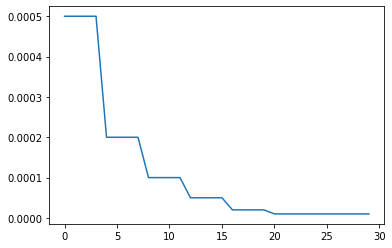

In [5]:
# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}

GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec') + tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')

TRAINING_FILENAMES_ONLY = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VAL_FILENAMES_ONLY =  tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')

TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']   


# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

    
def scheduler(epoch):
    if epoch < 4:
        return 0.0005
    elif epoch < 8:
        return 0.0002
    elif epoch < 12:
        return 0.0001
    elif epoch < 16:
        return 0.00005
    elif epoch < 20:
        return 0.00002
    else:
        return 0.00001
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = True)

rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]
y = [scheduler(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [6]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled = True, ordered = False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # Diregarding data order. Order does not matter since we will be shuffling the data anyway
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # use data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls = AUTO) # returns a dataset of (image, label) pairs if labeled = True or (image, id) pair if labeld = False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    return image, label   

def get_training_dataset(dataset,do_aug=True):
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    if do_aug: dataset = dataset.map(transform, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = int( count_data_items(TRAINING_FILENAMES) * (FOLDS-1.)/FOLDS )
NUM_VALIDATION_IMAGES = int( count_data_items(TRAINING_FILENAMES) * (1./FOLDS) )
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 10976 training images, 5488 validation images, 7382 unlabeled test images


# 3. Data Augmentation <a id="3"></a>

Big Thanks to Chris Deotte for this

<a href="https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96">Rotation Augmentation GPU/TPU - [0.96+]</a>

In [7]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

def transform(image,label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]),label


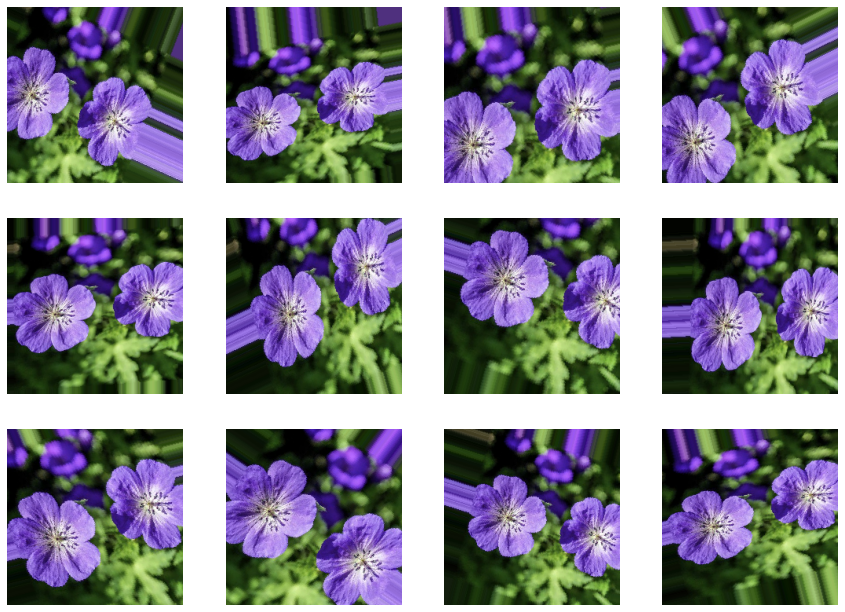

In [8]:
row = 3; col = 4;
all_elements = get_training_dataset(load_dataset(TRAINING_FILENAMES),do_aug=False).unbatch()
one_element = tf.data.Dataset.from_tensors( next(iter(all_elements)) )
augmented_element = one_element.repeat().map(transform).batch(row*col)

for (img,label) in augmented_element:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

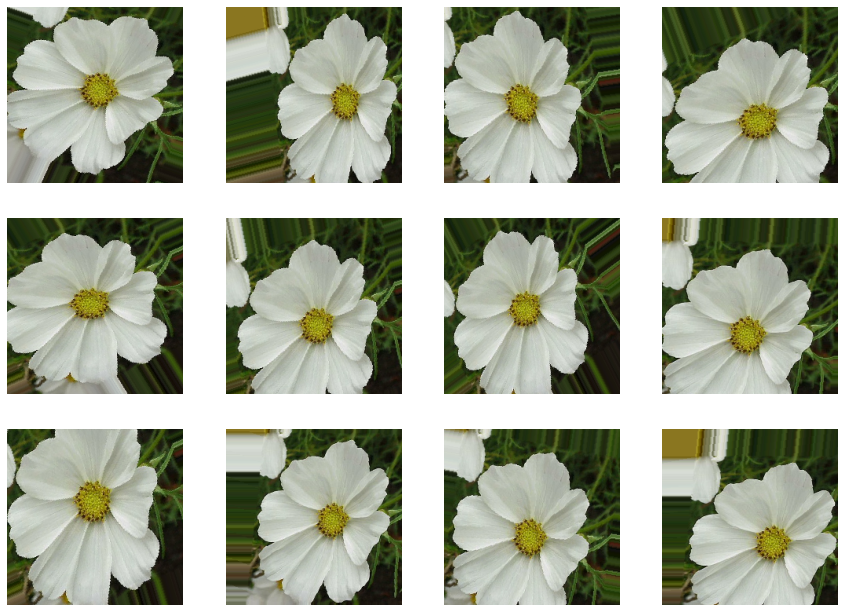

In [9]:
row = 3; col = 4;
all_elements = get_training_dataset(load_dataset(TRAINING_FILENAMES),do_aug=False).unbatch()
one_element = tf.data.Dataset.from_tensors( next(iter(all_elements)) )
augmented_element = one_element.repeat().map(transform).batch(row*col)

for (img,label) in augmented_element:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

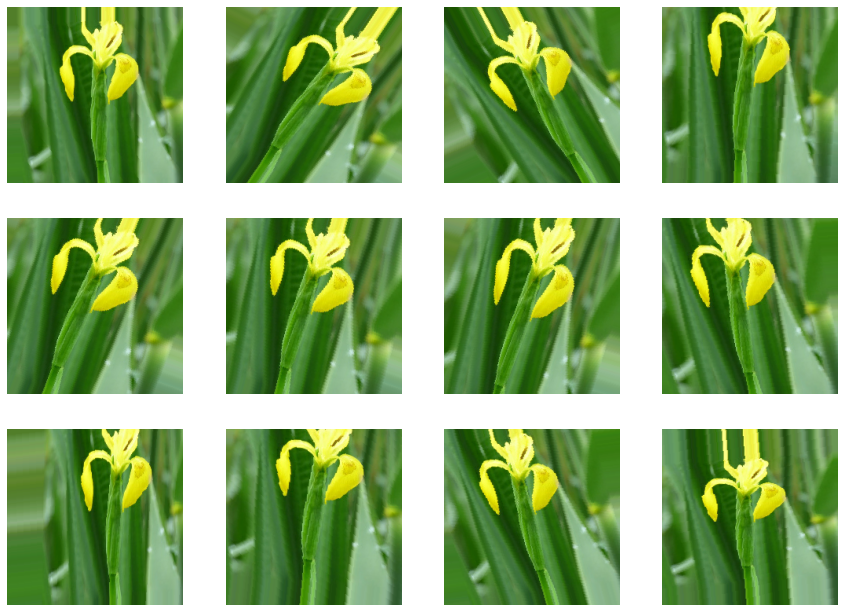

In [10]:
row = 3; col = 4;
all_elements = get_training_dataset(load_dataset(TRAINING_FILENAMES),do_aug=False).unbatch()
one_element = tf.data.Dataset.from_tensors( next(iter(all_elements)) )
augmented_element = one_element.repeat().map(transform).batch(row*col)

for (img,label) in augmented_element:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

# 4. Pretrained Models Creation <a id="4"></a>

In [11]:
# Create Test, TRain and validation Data

train_dataset_all = load_dataset(list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES})['TRAINING_FILENAMES']), labeled = True)
test_dataset_all = load_dataset(list(pd.DataFrame({'TEST_FILENAMES': TEST_FILENAMES})['TEST_FILENAMES']), labeled = True, ordered=True)

train_dataset = load_dataset(list(pd.DataFrame({'TRAINING_FILENAMES_ONLY': TRAINING_FILENAMES_ONLY})['TRAINING_FILENAMES_ONLY']), labeled = True)
val_dataset = load_dataset(list(pd.DataFrame({'VAL_FILENAMES_ONLY': VAL_FILENAMES_ONLY})['VAL_FILENAMES_ONLY']), labeled=True, ordered=True)


train_all = get_training_dataset(train_dataset_all) #Both validation and train concatenated for final fitting
test = get_test_dataset(test_dataset_all)
test_images_ds = test.map(lambda image, idnum: image)

train = get_training_dataset(train_dataset)
val = get_validation_dataset(val_dataset)

def Xception_model():
    with strategy.scope():
        rnet = Xception(
            input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights='imagenet',
            include_top=False
        )
        # trainable rnet
        rnet.trainable = True
        model = tf.keras.Sequential([
            rnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(len(CLASSES), activation='softmax',dtype='float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model

def VGG16_model():
    with strategy.scope():
        rnet = VGG16(
            input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights='imagenet',
            include_top=False
        )
        # trainable rnet
        rnet.trainable = True
        model = tf.keras.Sequential([
            rnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(len(CLASSES), activation='softmax',dtype='float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model

def DenseNet201_model():
    with strategy.scope():
        rnet = DenseNet201(
            input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights='imagenet',
            include_top=False
        )
        # trainable rnet
        rnet.trainable = True
        model = tf.keras.Sequential([
            rnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(len(CLASSES), activation='softmax',dtype='float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model

def InceptionV3_model():
    with strategy.scope():
        rnet = InceptionV3(
            input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights='imagenet',
            include_top=False
        )
        # trainable rnet
        rnet.trainable = True
        model = tf.keras.Sequential([
            rnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(len(CLASSES), activation='softmax',dtype='float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model

def EfficientNetB7_model():
    with strategy.scope():
        rnet = EfficientNetB7(
            input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights='imagenet',
            include_top=False
        )
        # trainable rnet
        rnet.trainable = True
        model = tf.keras.Sequential([
            rnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(len(CLASSES), activation='softmax',dtype='float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model

def ResNet152V2_model():
    with strategy.scope():
        rnet = ResNet152V2(
            input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights='imagenet',
            include_top=False
        )
        # trainable rnet
        rnet.trainable = True
        model = tf.keras.Sequential([
            rnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(len(CLASSES), activation='softmax',dtype='float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model

def MobileNetV2_model():
    with strategy.scope():
        rnet = MobileNetV2(
            input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights='imagenet',
            include_top=False
        )
        # trainable rnet
        rnet.trainable = True
        model = tf.keras.Sequential([
            rnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(len(CLASSES), activation='softmax',dtype='float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model

def InceptionResNetV2_model():
    with strategy.scope():
        rnet = InceptionResNetV2(
            input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights='imagenet',
            include_top=False
        )
        # trainable rnet
        rnet.trainable = True
        model = tf.keras.Sequential([
            rnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(len(CLASSES), activation='softmax',dtype='float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model

models = {'Xception' : Xception_model,
          'VGG16' : VGG16_model,
          'DenseNet201' : DenseNet201_model,
          'InceptionV3' : InceptionV3_model,
#          'EfficientNetB7' : EfficientNetB7_model, 
#           'ResNet152V2' : ResNet152V2_model, 
#           'MobileNetV2' : MobileNetV2_model, 
          'InceptionResNetV2' : InceptionResNetV2_model
         }
historys = {}
predictions = {}
predictions_val = {}
predictions_prob = {}
times = {}

MODELS_NUMBER = 5 #By RAM constraints i took only 5 models


# 5. Transfer Learning <a id="5"></a>

In [12]:
for name, model_ in models.items() :
    print('Running ' + name)
    model = model_()
    plot_model(model, to_file= name+'.png', show_shapes=True)
    
    history = model.fit(
        train, 
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs = EPOCHS,
        callbacks = [lr_callback],#, early_stopping],
        validation_data = val,
        verbose = 3
    )

    historys[name] = history # Save historys
    predictions_val[name] = np.argmax(model.predict(val), axis=-1)
#     Train on Train and validation Data for prediction
    del model
    gc.collect()
    
    model = model_()
    start_time = time.time()
    history = model.fit(
        train_all, 
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs = EPOCHS,
        callbacks = [lr_callback],#, early_stopping],
        verbose = 2
    )
    times[name] = "--- %s seconds ---" % (time.time() - start_time)   
    predictions_prob[name] = model.predict_proba(test_images_ds)
    predictions[name] = np.argmax(model.predict(test_images_ds), axis=-1)

Running Xception
83689472/83683744 [==============================] - 1s 0us/step

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 1/30

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 2/30

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 3/30

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 4/30

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 5/30

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 6/30

Epoch 00007: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 7/30

Epoch 00008: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 8/30

Epoch 00009: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 9/30

Epoch 00010: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 10/30

Epoch 00011: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 11/30

Epoch 00012: LearningRat

# 6. Evaluation and Performance Check <a id="6"></a>

## 6.1 Xception <a id="6.1"></a>

<img src="https://i.postimg.cc/PJrq7DL0/Xception.png" align="right" width="500" height="200">

interpretation of Inception modules in convolutional neural networks as being an intermediate step in-between regular convolution and the depthwise separable convolution operation (a depthwise convolution followed by a pointwise convolution). In this light, a depthwise separable convolution can be understood as an Inception module with a maximally large number of towers. This observation leads us to propose a novel deep convolutional neural network architecture inspired by Inception, where Inception modules have been replaced with depthwise separable convolutions. We show that this architecture, dubbed Xception, slightly outperforms Inception V3 on the ImageNet dataset (which Inception V3 was designed for), and significantly outperforms Inception V3 on a larger image classification dataset comprising 350 million images and 17,000 classes. Since the Xception architecture has the same number of parameters as Inception V3, the performance gains are not due to increased capacity but rather to a more efficient use of model parameters.

<a href="https://arxiv.org/abs/1610.02357">Xception: Deep Learning with Depthwise Separable Convolutions</a>

<BR CLEAR=”left” />

In [13]:
def plot_perf(name) :
    
    print('{} Training took {}'.format(name, times[name]))
    
    history = historys[name]

    fig = plt.figure(figsize = [30,5])

    plt.subplot(1, 3, 1)

    img=mpimg.imread(name+'.png')
    plt.title(name + ' Architecture')
    plt.imshow(img)

    plt.subplot(1, 3, 2)

    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title(name + ' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.subplot(1, 3, 3)

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(name + ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    

Xception Training took --- 268.7530002593994 seconds ---


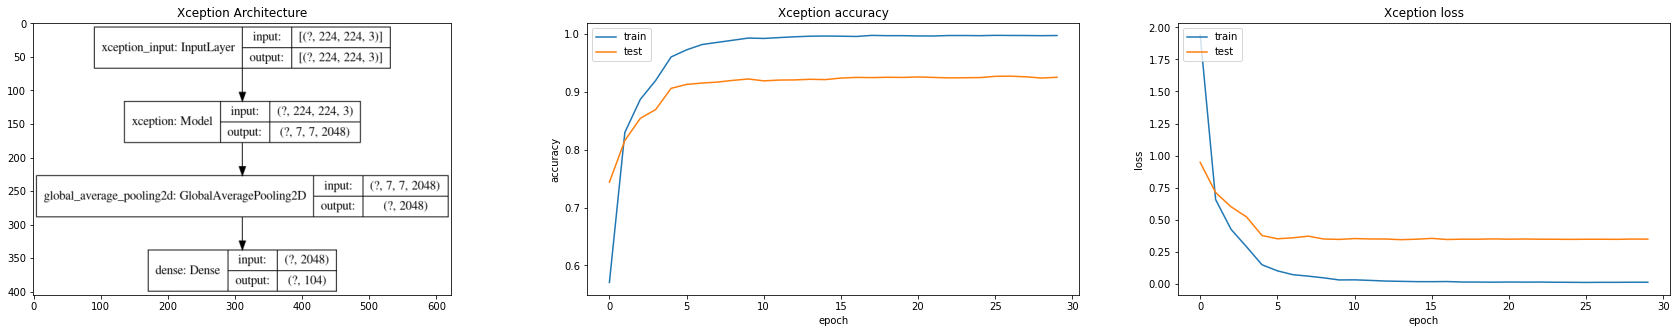

In [14]:
plot_perf('Xception')

In [15]:
# tf.data.Dataset.from_tensor_slices(list(val))

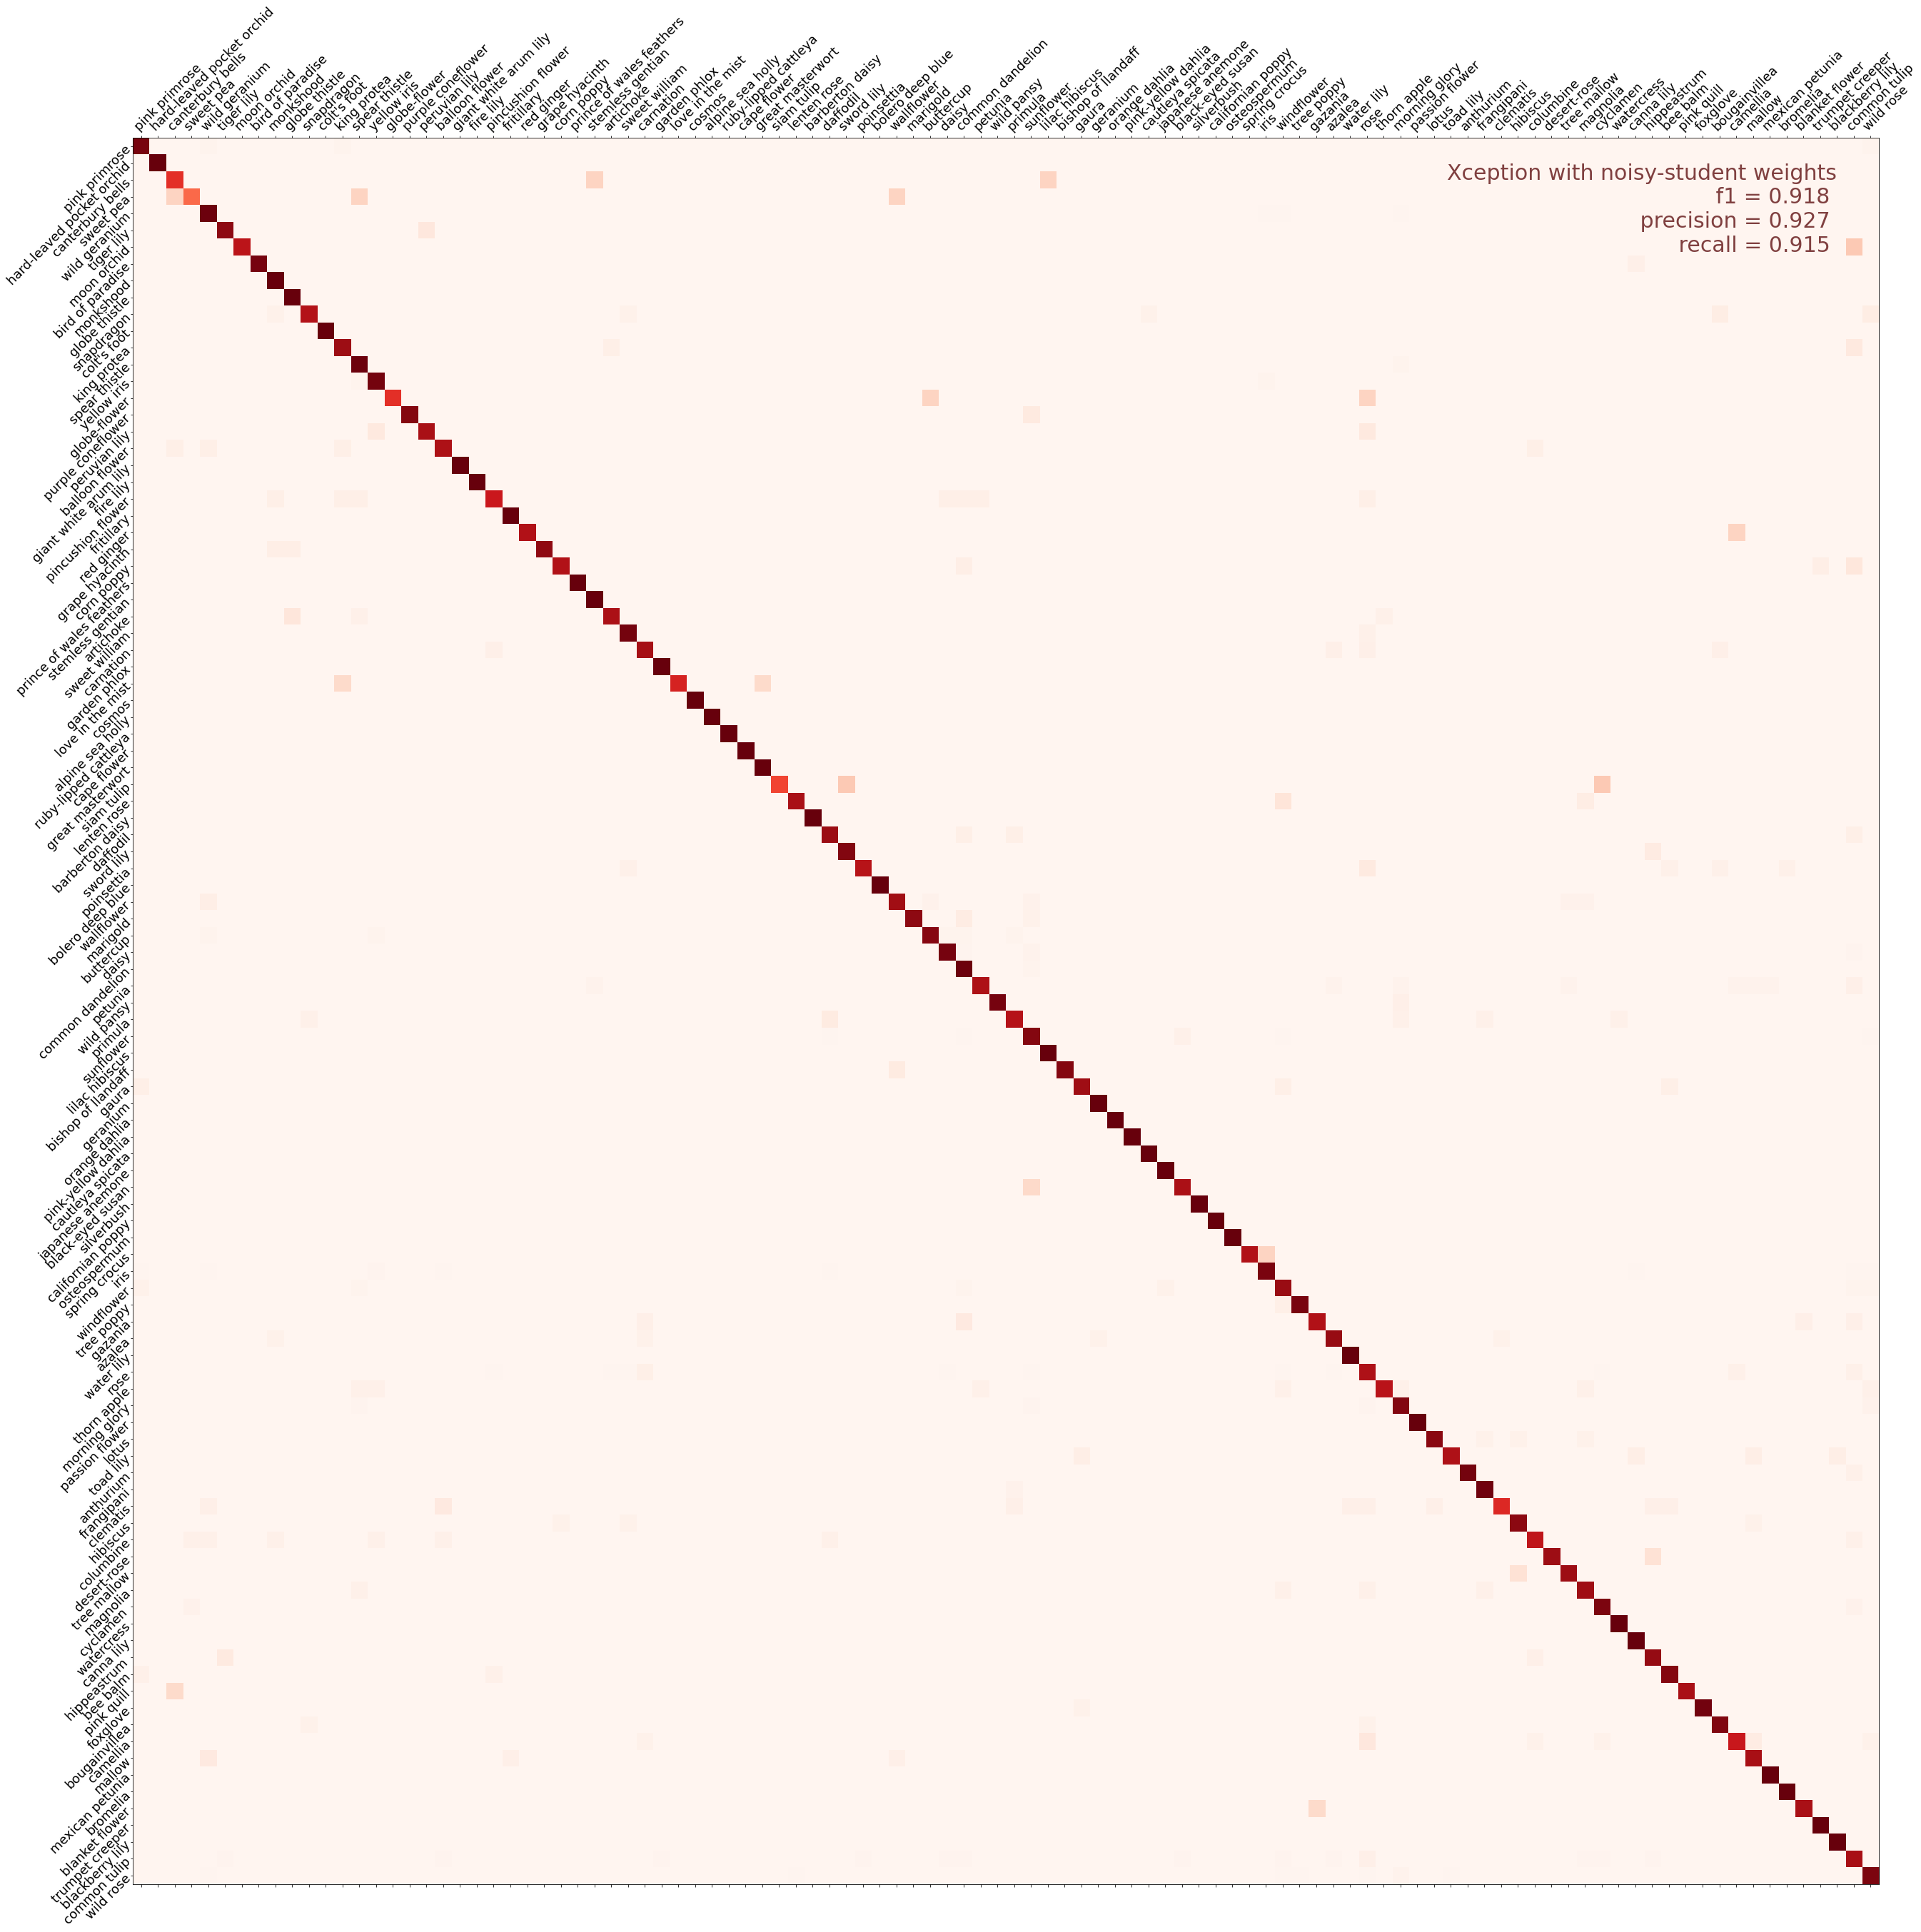

f1 score: 0.918, precision: 0.927, recall: 0.915


In [16]:
def display_confusion_matrix(cmat, score, precision, recall, name):
    plt.figure(figsize=(45,45))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 18})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 18})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = name + " with noisy-student weights"
    if score is not None:
        titlestring += '\n f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\n precision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\n recall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 30, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()

cmdataset = val
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() 
# cm_probabilities = model1.predict(images_ds)
cm_predictions = predictions_val['Xception']
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
cmat = (cmat.T / cmat.sum(axis=1)).T 
display_confusion_matrix(cmat, score, precision, recall, 'Xception')
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

* Xception took about 4 minutes for 30 epochs.
* Relatively large difference in performance between train data and validation. is it mini a overfitting ?
* Good performances f1 score: 0.921, precision: 0.929, recall: 0.919


## 6.2 VGG16 <a id="6.2"></a>

VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”. The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes. It was one of the famous model submitted to ILSVRC-2014. It makes the improvement over AlexNet by replacing large kernel-sized filters (11 and 5 in the first and second convolutional layer, respectively) with multiple 3×3 kernel-sized filters one after another. VGG16 was trained for weeks and was using NVIDIA Titan Black GPU’s.

<a href="https://arxiv.org/pdf/1409.1556.pdf">Very Deep Convolutional Networks for Large-Scale Image Recognition</a>

<img src="https://i.postimg.cc/CMDFSSpz/vgg16.png" width="500" height="1000">

VGG16 Training took --- 208.52590537071228 seconds ---


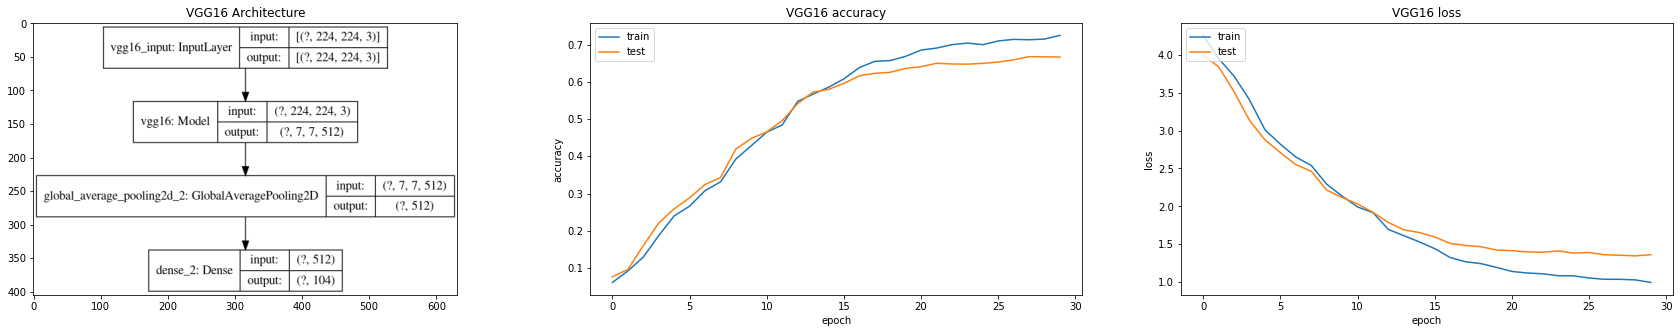

In [17]:
plot_perf('VGG16')

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


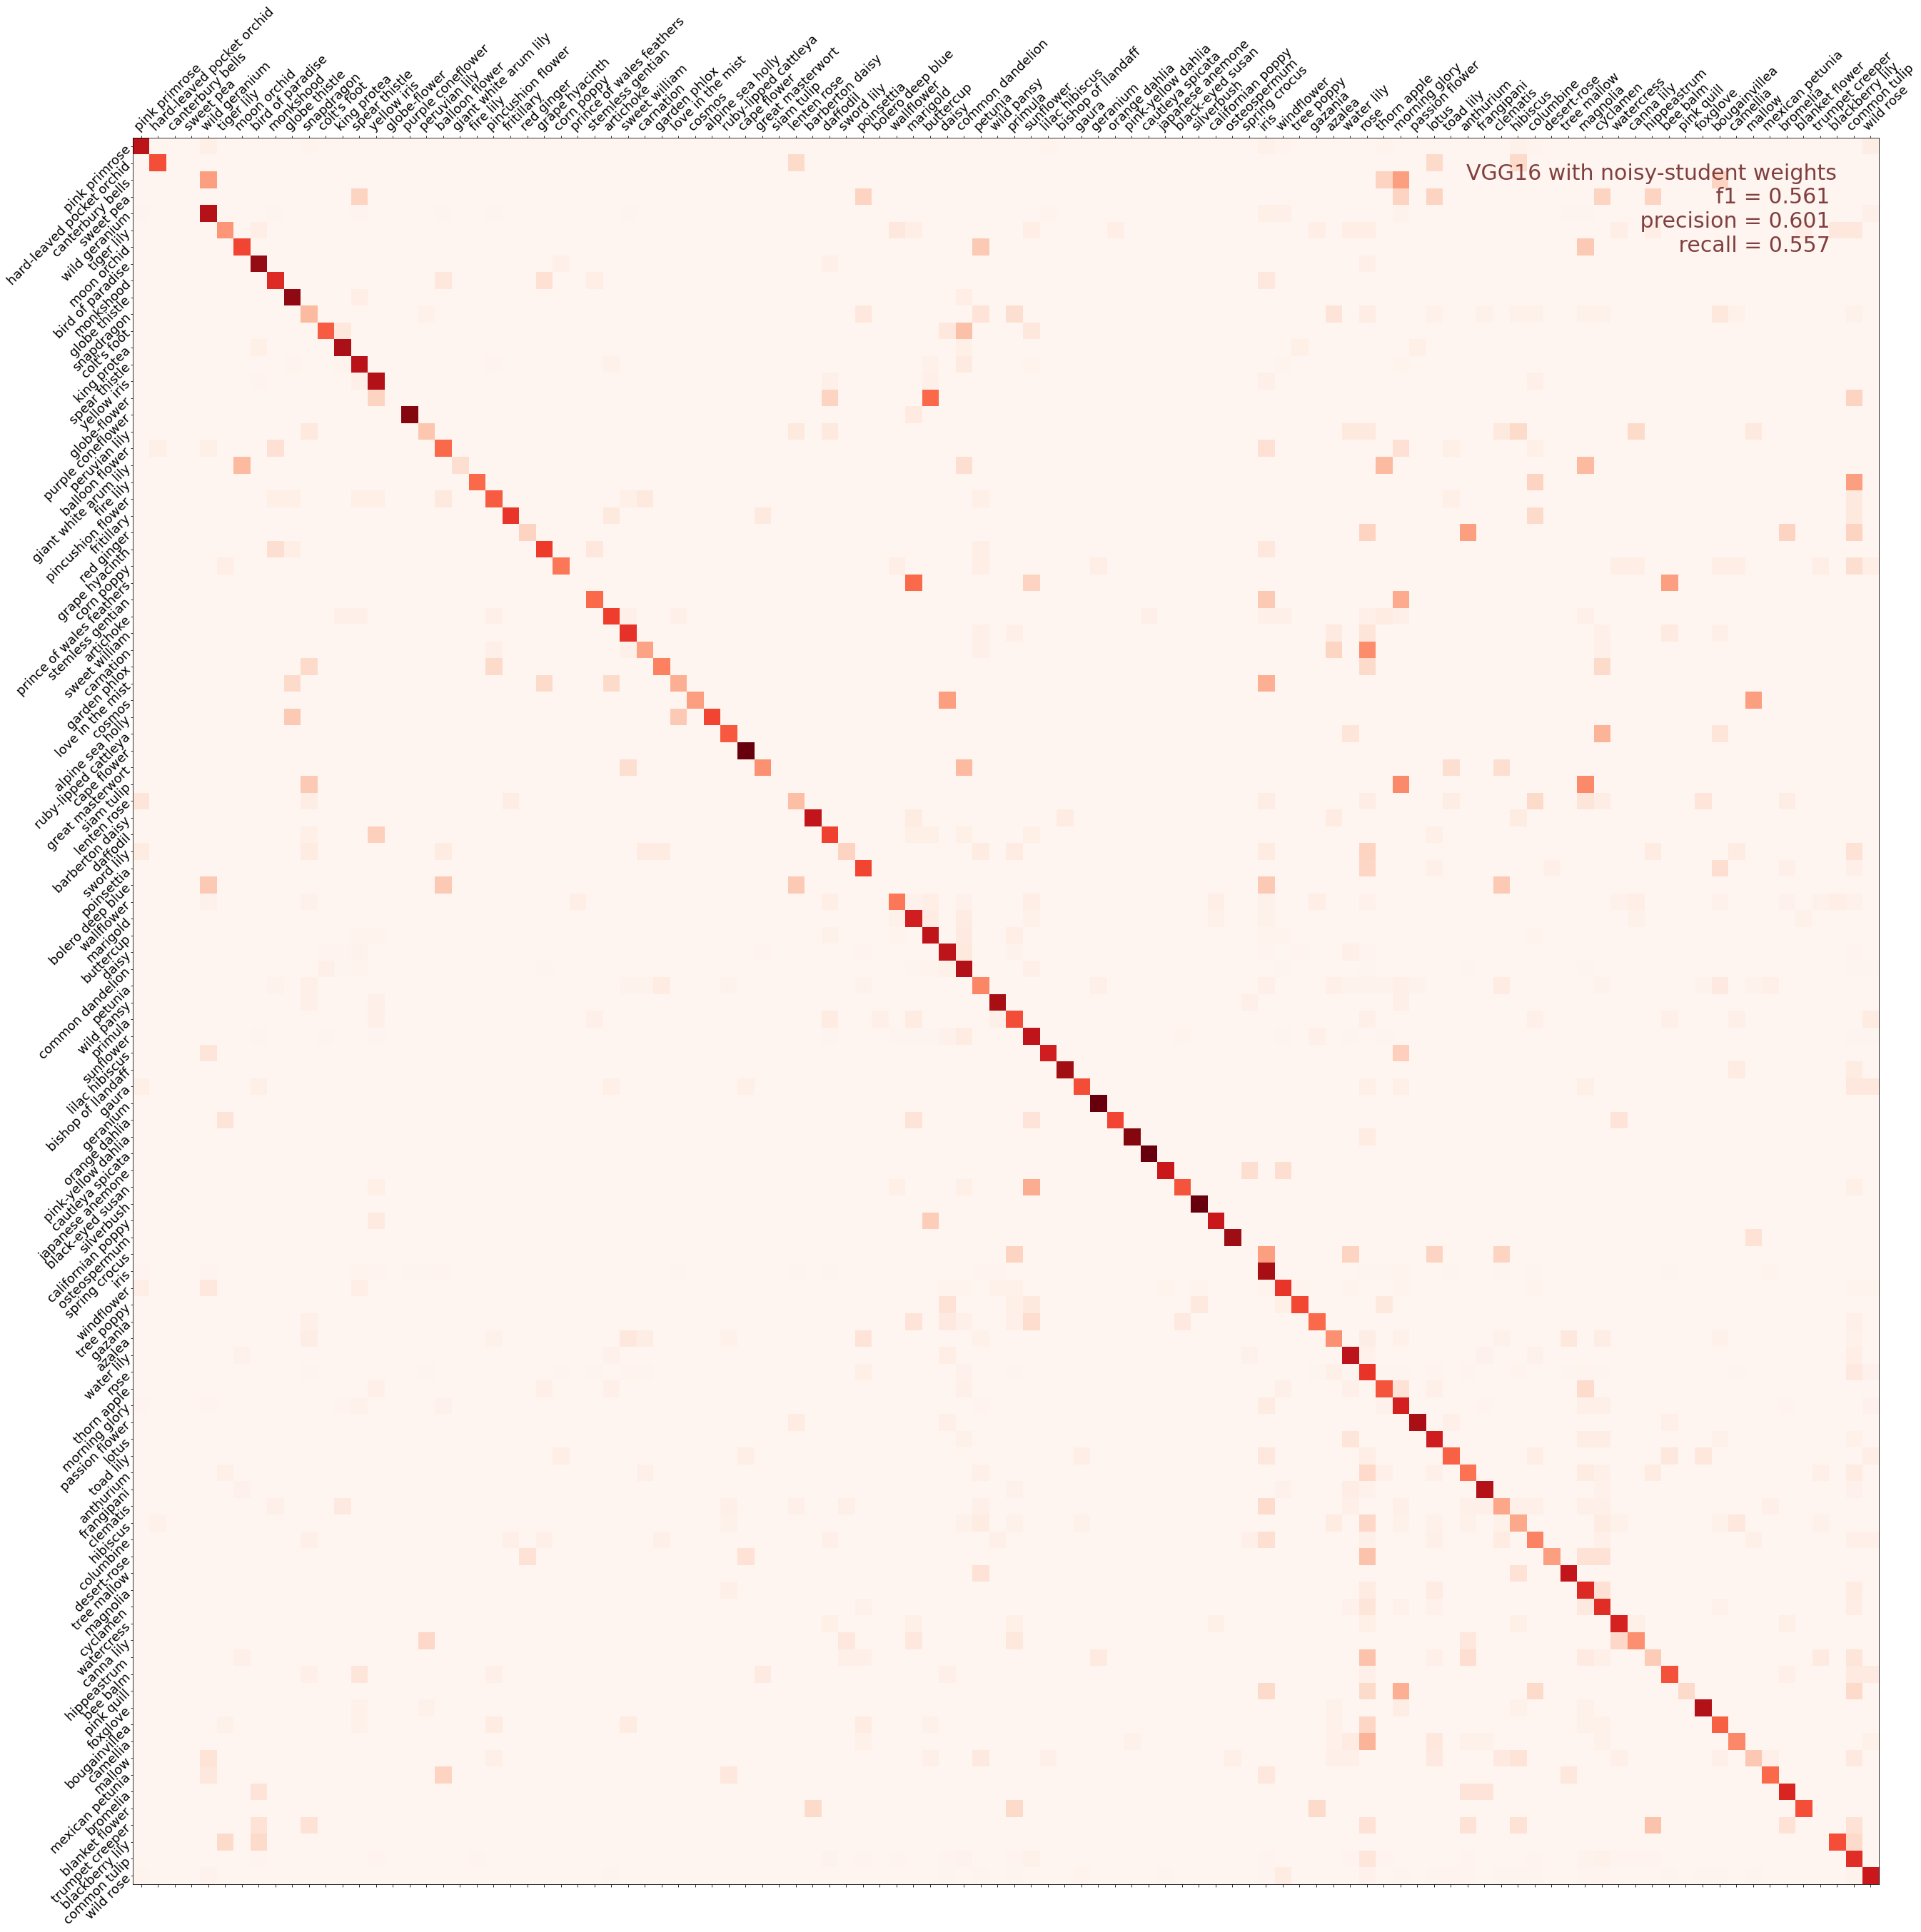

f1 score: 0.561, precision: 0.601, recall: 0.557


In [18]:
def display_confusion_matrix(cmat, score, precision, recall, name):
    plt.figure(figsize=(45,45))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 18})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 18})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = name + " with noisy-student weights"
    if score is not None:
        titlestring += '\n f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\n precision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\n recall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 30, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()

cmdataset = val
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() 
# cm_probabilities = model1.predict(images_ds)
cm_predictions = predictions_val['VGG16']
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
cmat = (cmat.T / cmat.sum(axis=1)).T 
display_confusion_matrix(cmat, score, precision, recall, 'VGG16')
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

* VGG16 took about 3 minute.
* Slow gradient descent maybe biger LR would be better.
* relativly bad performances : f1 score: 0.563, precision: 0.614, recall: 0.556

## 6.3 DenseNet201 <a id="6.3"></a>

Recent work has shown that convolutional networks can be substantially
deeper, more accurate, and efficient to train if they contain shorter
connections between layers close to the input and those close to the output. In
this paper, we embrace this observation and introduce the Dense Convolutional
Network (DenseNet), which connects each layer to every other layer in a
feed-forward fashion. Whereas traditional convolutional networks with L layers
have L connections - one between each layer and its subsequent layer - our
network has L(L+1)/2 direct connections. For each layer, the feature-maps of
all preceding layers are used as inputs, and its own feature-maps are used as
inputs into all subsequent layers. DenseNets have several compelling
advantages: they alleviate the vanishing-gradient problem, strengthen feature
propagation, encourage feature reuse, and substantially reduce the number of
parameters. We evaluate our proposed architecture on four highly competitive
object recognition benchmark tasks (CIFAR-10, CIFAR-100, SVHN, and ImageNet).
DenseNets obtain significant improvements over the state-of-the-art on most of
them, whilst requiring less computation to achieve high performance. Code and
pre-trained models are available at <a class="link-external link-https" href="https://github.com/liuzhuang13/DenseNet" rel="external noopener nofollow">this https URL</a> .

<a href="https://arxiv.org/pdf/1608.06993.pdf">Densely Connected Convolutional Networks</a>

<img src="https://i.postimg.cc/wTjFpxSp/wWHWbQt.png" width="500" height="1000">


DenseNet201 Training took --- 689.65975522995 seconds ---


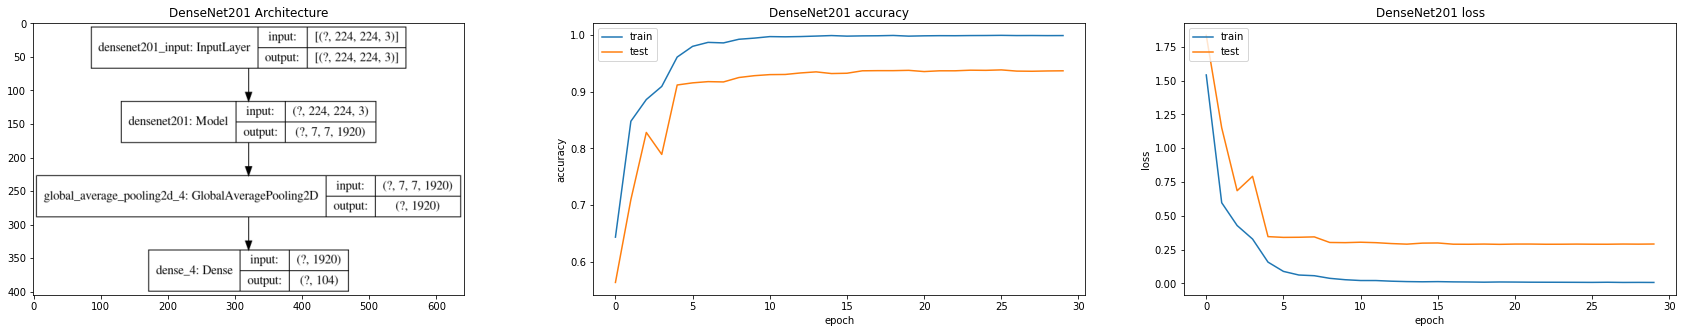

In [19]:
plot_perf('DenseNet201')

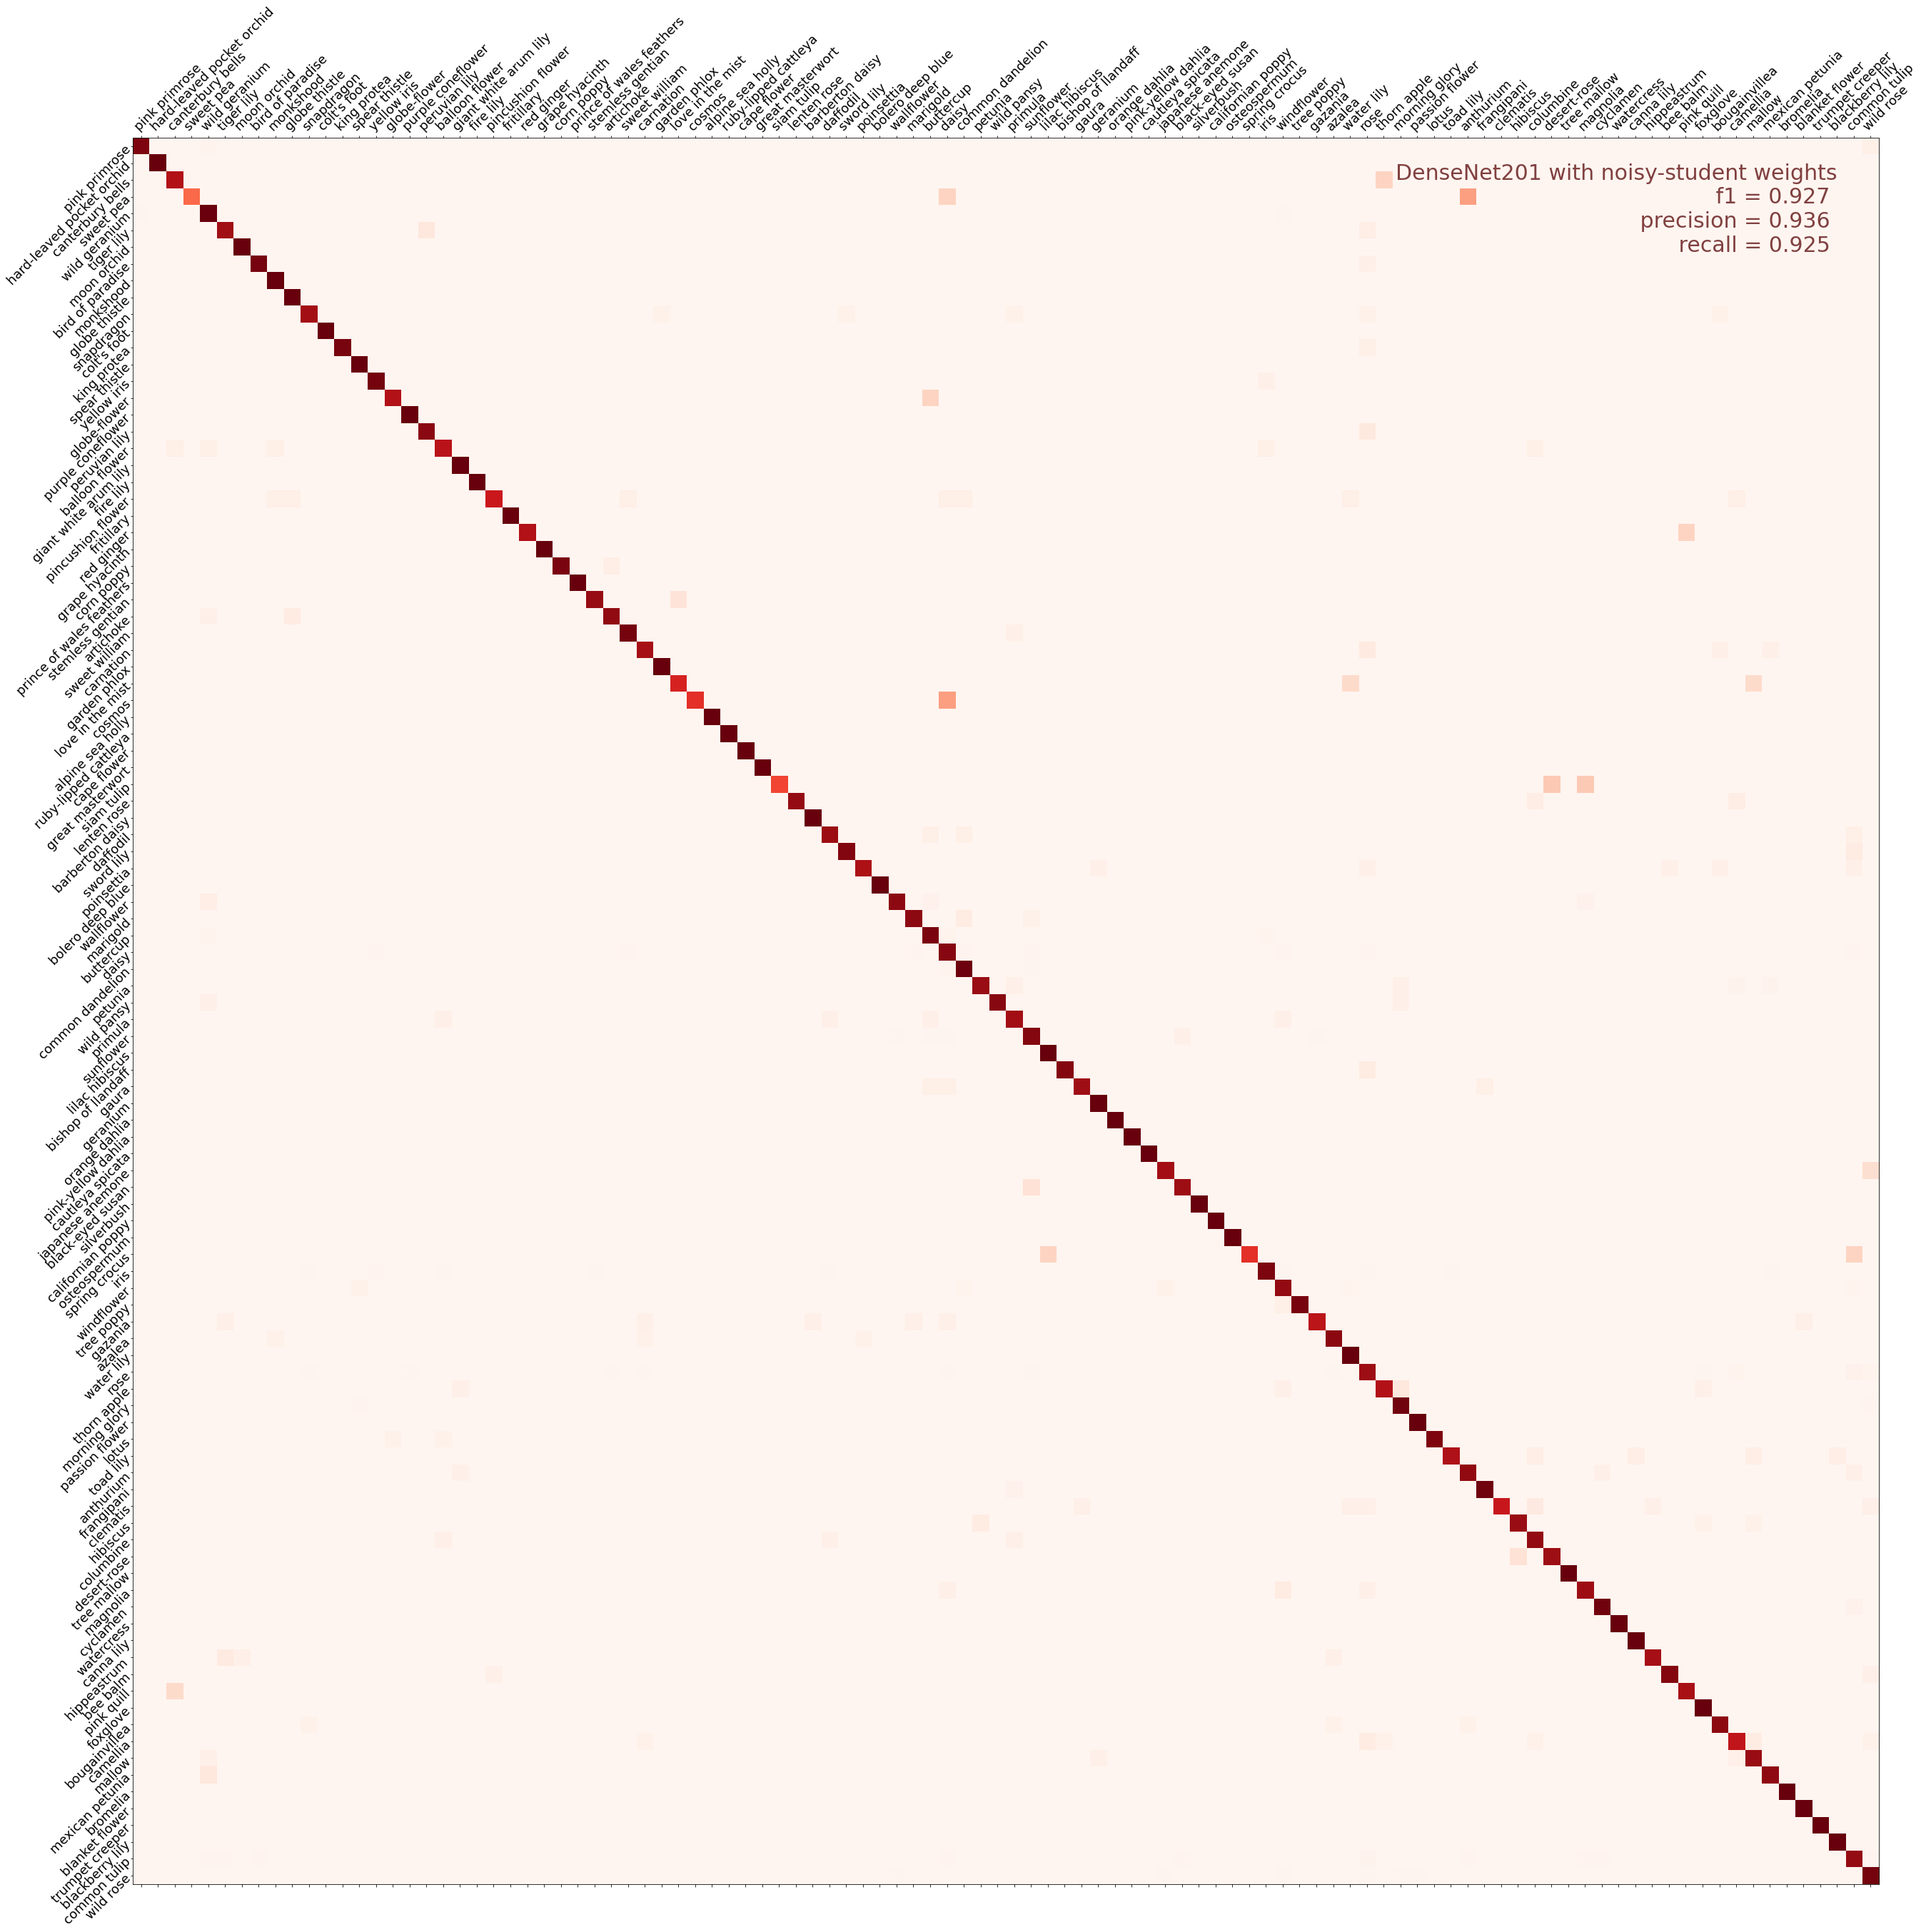

f1 score: 0.927, precision: 0.936, recall: 0.925


In [20]:
def display_confusion_matrix(cmat, score, precision, recall, name):
    plt.figure(figsize=(45,45))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 18})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 18})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = name + " with noisy-student weights"
    if score is not None:
        titlestring += '\n f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\n precision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\n recall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 30, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()

cmdataset = val
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() 
# cm_probabilities = model1.predict(images_ds)
cm_predictions = predictions_val['DenseNet201']
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
cmat = (cmat.T / cmat.sum(axis=1)).T 
display_confusion_matrix(cmat, score, precision, recall, 'DenseNet201')
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

* DenseNet201 took about 11 minutes which is relatively long.
* Seems to be a disturbance at first and it is stabilized but there is a gap between the test and is the same as Xception.
* Good performances : f1 score: 0.936, precision: 0.940, recall: 0.936

## 6.4 InceptionV3 <a id="6.4"></a>

Convolutional networks are at the core of most state-of-the-art computer vision solutions for a wide variety of tasks. Since 2014 very deep convolutional networks started to become mainstream, yielding substantial gains in various benchmarks. Although increased model size and computational cost tend to translate to immediate quality gains for most tasks (as long as enough labeled data is provided for training), computational efficiency and low parameter count are still enabling factors for various use cases such as mobile vision and big-data scenarios. Here we explore ways to scale up networks in ways that aim at utilizing the added computation as efficiently as possible by suitably factorized convolutions and aggressive regularization. We benchmark our methods on the ILSVRC 2012 classification challenge validation set demonstrate substantial gains over the state of the art: 21.2% top-1 and 5.6% top-5 error for single frame evaluation using a network with a computational cost of 5 billion multiply-adds per inference and with using less than 25 million parameters. With an ensemble of 4 models and multi-crop evaluation, we report 3.5% top-5 error on the validation set (3.6% error on the test set) and 17.3% top-1 error 
on the validation set.

<a href="https://arxiv.org/abs/1512.00567">Rethinking the Inception Architecture for Computer Vision</a>

<img src="https://i.postimg.cc/0jK7QYBS/68747470733a2f2f7777772e50657465724d6f7373416d6c416c6c52657365617263682e636f6d2f6d656469612f696d6167.jpg" width="500" height="1000">

InceptionV3 Training took --- 324.6902754306793 seconds ---


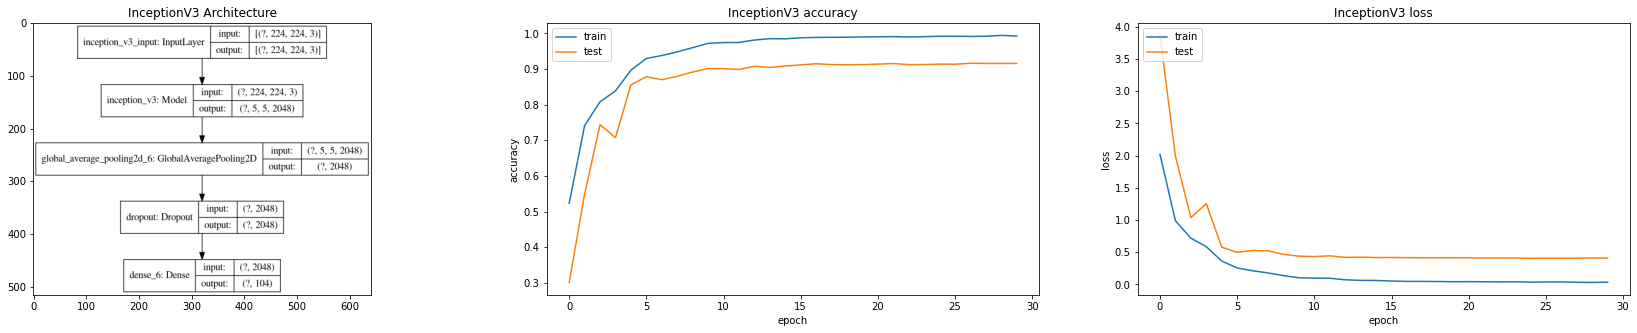

In [21]:
plot_perf('InceptionV3')

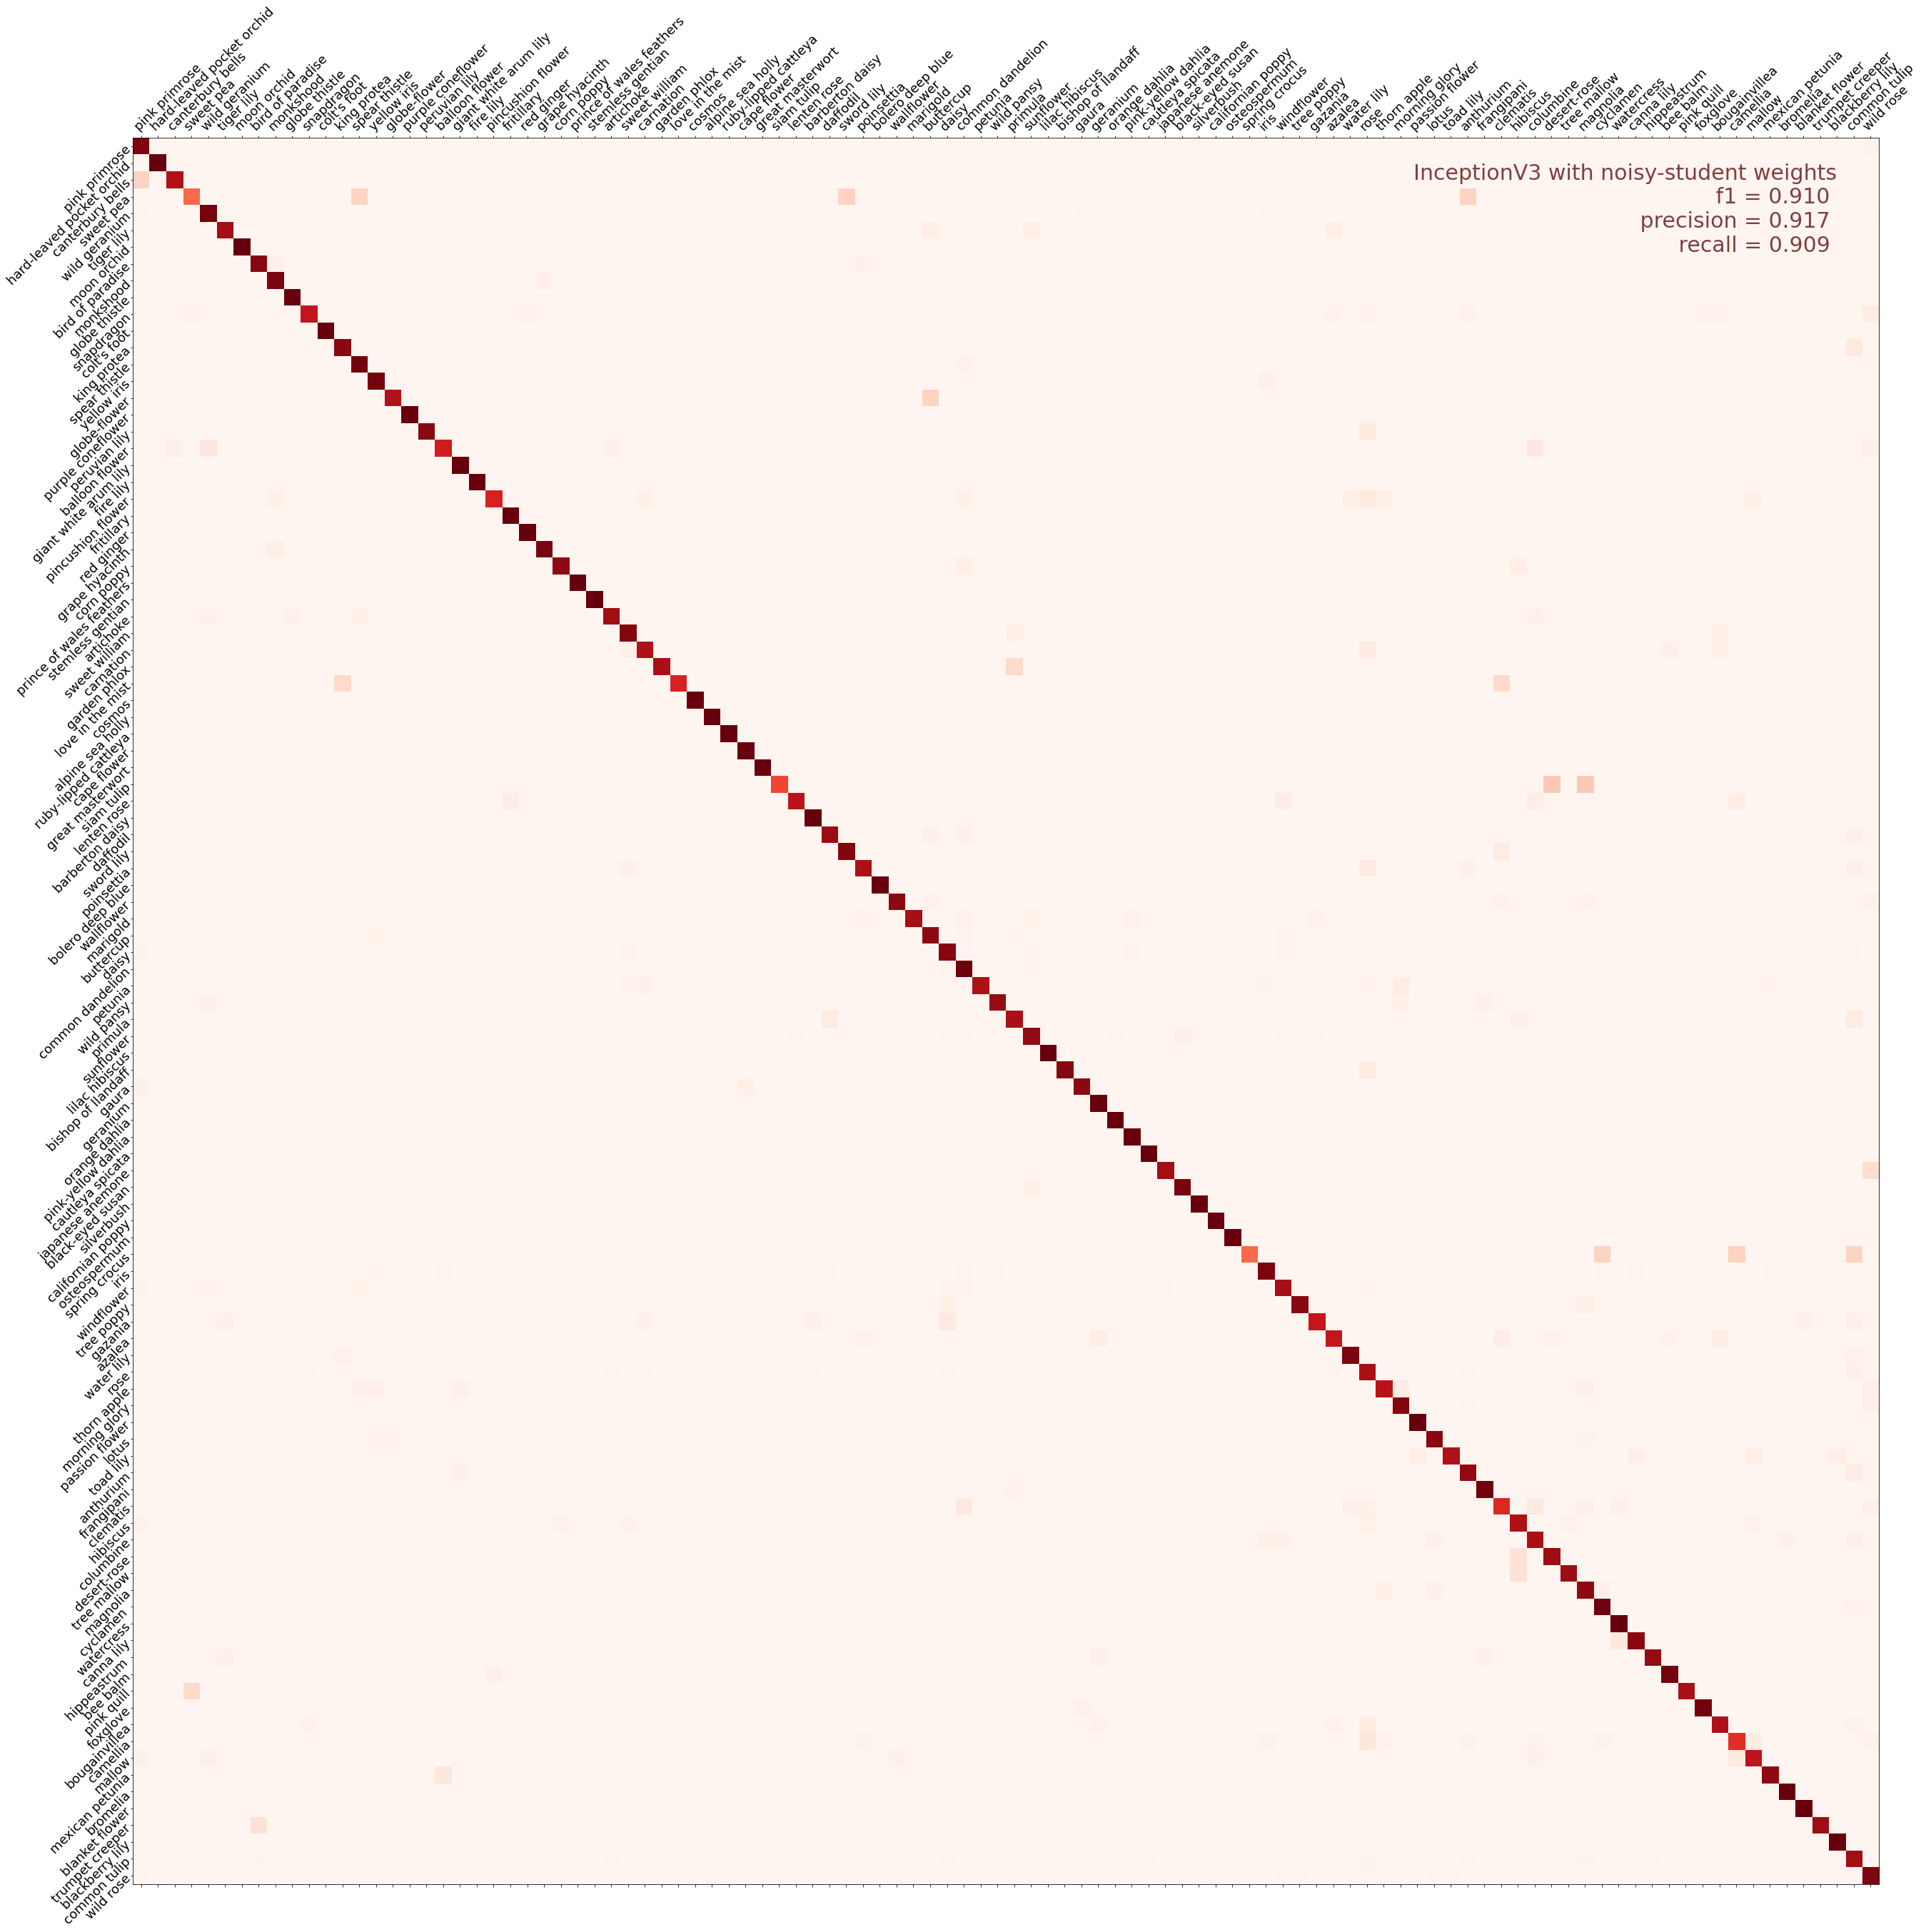

f1 score: 0.910, precision: 0.917, recall: 0.909


In [22]:
def display_confusion_matrix(cmat, score, precision, recall, name):
    plt.figure(figsize=(45,45))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 18})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 18})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = name + " with noisy-student weights"
    if score is not None:
        titlestring += '\n f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\n precision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\n recall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 30, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()

cmdataset = val
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() 
# cm_probabilities = model1.predict(images_ds)
cm_predictions = predictions_val['InceptionV3']
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
cmat = (cmat.T / cmat.sum(axis=1)).T 
display_confusion_matrix(cmat, score, precision, recall, 'InceptionV3')
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

* InceptionV3 took about 5.38.
* Good progression of the accuracy and loss but there is a gap between the test and val.
* good performances : f1 score: 0.903, precision: 0.912, recall: 0.903

## 6.5 InceptionResNetV2 <a id="6.6"></a>

Very deep convolutional networks have been central to the largest advances in image recognition performance in recent years. One example is the Inception architecture that has been shown to achieve very good performance at relatively low computational cost. Recently, the introduction of residual connections in conjunction with a more traditional architecture has yielded state-of-the-art performance in the 2015 ILSVRC challenge; its performance was similar to the latest generation Inception-v3 network. This raises the question of whether there are any benefit in combining the Inception architecture with residual connections. Here we give clear empirical evidence that training with residual connections accelerates the training of Inception networks significantly. There is also some evidence of residual Inception networks outperforming similarly expensive Inception networks without residual connections by a thin margin. We also present several new streamlined architectures for both residual and non-residual Inception networks. These variations improve the single-frame recognition performance on the ILSVRC 2012 classification task significantly. We further demonstrate how proper activation scaling stabilizes the training of very wide residual Inception networks. With an ensemble of three residual and one Inception-v4, we achieve 3.08 percent top-5 error on the test set of the ImageNet classification (CLS) challenge.

<a href="https://arxiv.org/pdf/1602.07261.pdf">Inception-v4, Inception-ResNet and the Impact of Residual Connections on Learning</a>

<img src="https://i.postimg.cc/mk8dGNKG/image00.png" width="500" height="1000">

InceptionResNetV2 Training took --- 658.0854969024658 seconds ---


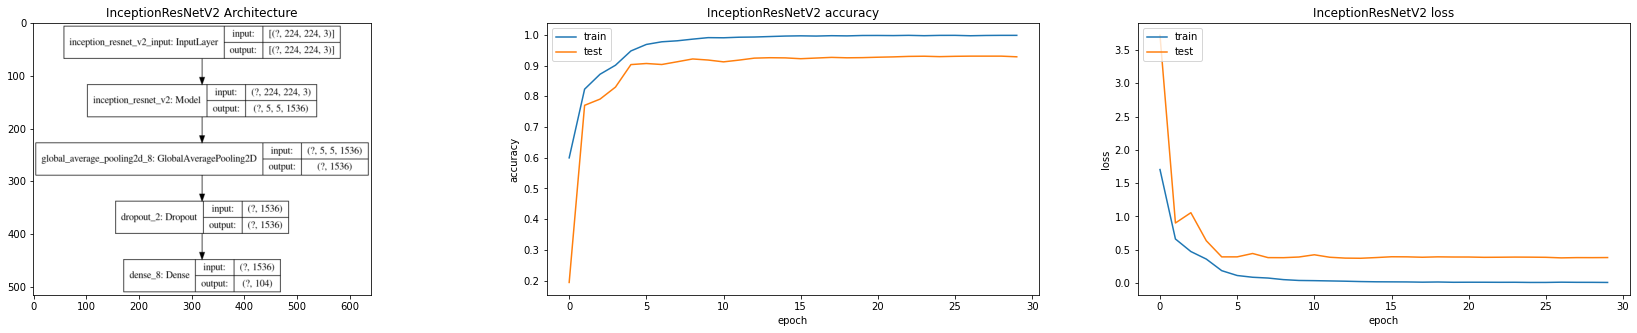

In [23]:
plot_perf('InceptionResNetV2')

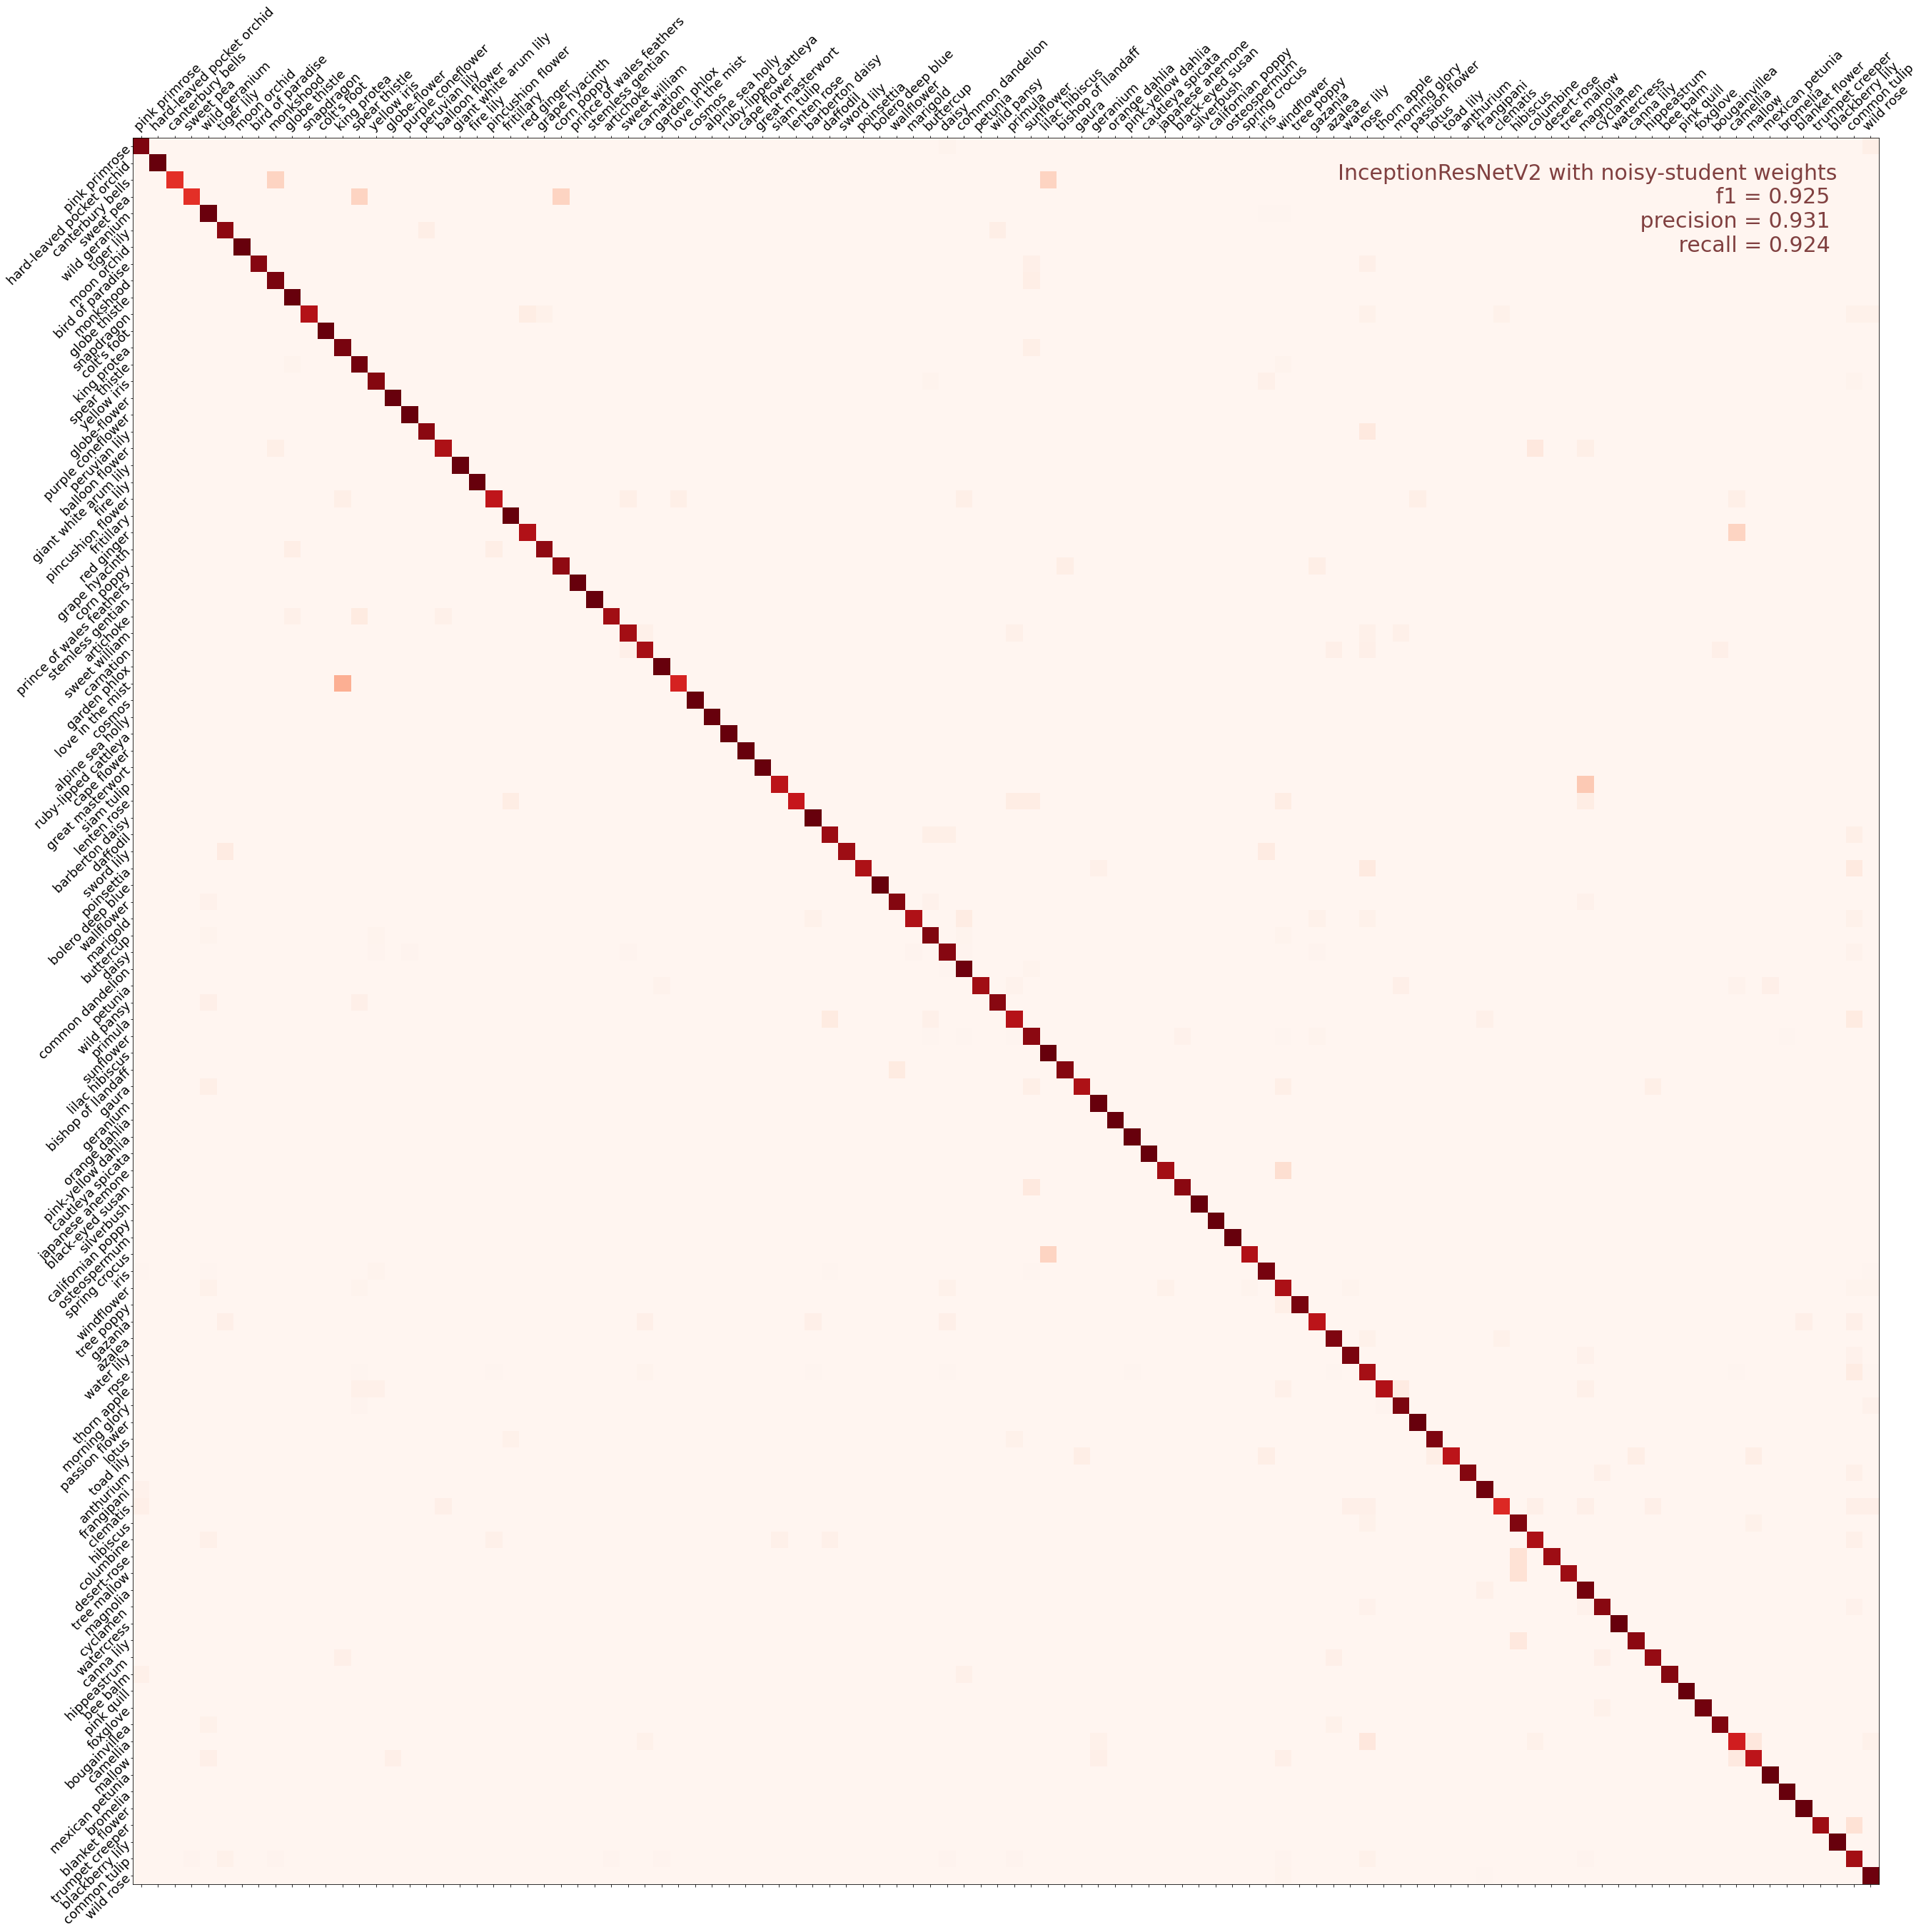

f1 score: 0.925, precision: 0.931, recall: 0.924


In [24]:
def display_confusion_matrix(cmat, score, precision, recall, name):
    plt.figure(figsize=(45,45))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 18})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 18})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = name + " with noisy-student weights"
    if score is not None:
        titlestring += '\n f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\n precision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\n recall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 30, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()

cmdataset = val
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() 
# cm_probabilities = model1.predict(images_ds)
cm_predictions = predictions_val['InceptionResNetV2']
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
cmat = (cmat.T / cmat.sum(axis=1)).T 
display_confusion_matrix(cmat, score, precision, recall, 'InceptionResNetV2')
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

* ResNet152V2 took about 10 minutes.
* Good progression of accuracy and loss, maybe the best.
* Best performances : f1 score: 0.927, precision: 0.934, recall: 0.925

# 7. Assembling and Submission <a id="7"></a>

In [25]:
df = pd.DataFrame(predictions)
pred = []
for i in range(0, 7382) :
    if df.loc[i,:].unique().shape[0] < MODELS_NUMBER :
        pred.append(stats.mode(df.loc[i,:].values)[0][0])
    else :
        pred.append(df.loc[i,'InceptionResNetV2'])
        
df = pd.DataFrame(predictions_val)
pred_val = []
for i in range(0, 3712) :
    if df.loc[i,:].unique().shape[0] < MODELS_NUMBER :
        pred_val.append(stats.mode(df.loc[i,:].values)[0][0])
    else :
        pred_val.append(df.loc[i,'InceptionResNetV2'])

avg_prob = predictions_prob['Xception'] + predictions_prob['VGG16'] + predictions_prob['DenseNet201'] + predictions_prob['InceptionV3'] + predictions_prob['InceptionResNetV2']
pred_avg = pd.DataFrame(np.argmax(avg_prob, axis=-1))

In [26]:
test_ids_ds = test.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission_vote.csv', np.rec.fromarrays([test_ids, pred]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, np.argmax(avg_prob, axis=-1)]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')

# 8. Conclusion <a id="8"></a>

We can not extrapolate on what has just happened because it is related to the problematic, each model has its proliferation medium they can perform well on a set of images as it can not perform on another.

And also I want to clarify that I used the same hyperparameters for each model, if we change them that is likely to change.

However, this gives us an overall idea of the performance of each and personally I chose InceptionResNetV2 it is good.

Upvote if u like it =) Bye.

<img src="https://i.postimg.cc/jj4ywbXF/time-100-influential-photos-neil-leifer-muhammad-ali-vs-sonny-liston-56.jpg" alt="Flowers" class="center">